<a href="https://colab.research.google.com/github/01-Projects-In-Python/Project-PCA-ArticleStressMonitoring/blob/main/Code-Project-PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT - Principal Component Analysis (PCA)

### Group Members:
- Mary Alexandra Garcia
- Yamileth Hercules

__a. Purpose:__<br>
Explore methods to reduce dimensions for the physiological signals
dataset using PCA.

__b. Objectives:__<br>
  
1. EDA (This part is the same assigment 1)
2. Identify ways to reduce dimensions of the datasets.<br>
3. Implement PCA to reduce the dataset's dimensions.<br>
4. Conduct the prediction tasks using the linear model. <br>
5. Interpret the result of the predictions.<br>
6. Compare the results of the model with the initial dataset vs the dataset reduced.<br>
7. Conclusions.<br>

__b. Data:__<br>

The data is the one that is provide in GitHub about the stress experiment. We can see as follow the description of the variables:


| Variable | Description|
| --- | --- |
| Participant | Number of Particpant in the experiment|
| HR| Heart for every second during the test|  
| RR| respiratory Rate for every second during the test |
| Time| Time in timestamp UNITs|
| Label| Binary variable 0= normal, 1= stress situations|

[Stress Monitoring Using Wearable Sensors Study Link Here](https://www.mdpi.com/1424-8220/22/21/8135)

## Objective 1: Conduct an EDA analysis on the given dataset.

In [ ]:
#!pip install -q statsmodels


In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=dc8ff3eaec8a1dd341dfc131ec5d473052327a8ef162dec79b0292aa1fee8c76
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score
%matplotlib inline


In [ ]:
df = pd.read_csv('Improved_All_Combined_hr_rsp_binary.csv')
df.head()

,Participant,HR,respr,Time(sec),Label
0,2,118.00,12.127693,1644227583,0
1,2,113.50,12.127693,1644227584,0
2,2,93.00,12.127693,1644227585,0
3,2,93.25,12.127693,1644227586,0
4,2,86.40,12.127693,1644227587,0


In order to simplify the analysis of the data, we will modify the columns' names:

In [ ]:
df.rename(columns={'Time(sec)': 'Time', 'Label': 'Group'}, inplace=True)

In [ ]:
# Verifying the data shape
df.shape

(112516, 5)

##### **- Missing values:**

In [ ]:
# Checking missing values
df.isnull().sum()

Participant     0
HR             44
respr           0
Time            0
Group           0
dtype: int64

As we can see, the 'HR' variable contains 44 null values, therefore, we will drop them based on they represent less than 5% of the data and we want to use the same observations that are used in the study:

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Checking null values
df.isnull().sum()

Participant    0
HR             0
respr          0
Time           0
Group          0
dtype: int64

In [ ]:
# Verifying the type of variables that we have in the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112472 entries, 0 to 112515
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Participant  112472 non-null  int64  
 1   HR           112472 non-null  float64
 2   respr        112472 non-null  float64
 3   Time         112472 non-null  int64  
 4   Group        112472 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 5.1 MB


We can see that the values for the 'Time' variables do not make sense so we will transform the `Time` and get the exact time in Hours.

In [ ]:
df['Time'] = df.groupby('Participant')['Time'].transform(lambda x: (x - x.min())/3600)

With the above transformation we allowed that `Time` is and hours as mentioned in the article.

In [ ]:
df.head()

,Participant,HR,respr,Time,Group
0,2,118.00,12.127693,0.000000,0
1,2,113.50,12.127693,0.000278,0
2,2,93.00,12.127693,0.000556,0
3,2,93.25,12.127693,0.000833,0
4,2,86.40,12.127693,0.001111,0


##### **- Data distribution:**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Participant,112472.0,18.475923,9.871188,2.000000,10.000000,18.000000,27.000000,35.000000
HR,112472.0,80.216177,12.732206,49.000000,71.330000,77.890000,87.020000,146.780000
respr,112472.0,12.465400,2.030968,5.204728,11.191836,12.743508,13.877583,18.163532
Time,112472.0,0.460113,0.266660,0.000000,0.229653,0.459306,0.688958,0.990278
Group,112472.0,0.327326,0.469239,0.000000,0.000000,0.000000,1.000000,1.000000


#### - Interpretation:
* As we can see the describe function takes `Group` as a continuous variable even though is a binary variable because we did not specify that is a categorical variable.
* The variable `Time` is a Unix timestamp that is measured in seconds and after we transform we got hours.
* The Standard deviation of HR is very high which represents that might be skewness in the data.


In [ ]:
df.groupby('Participant')['HR'].agg(['min', 'max', 'mean', 'median','std']).T

Participant,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,33,34,35
min,58.220000,59.150000,62.650000,58.480000,58.000000,59.570000,62.380000,59.780000,58.930000,52.000000,...,54.300000,60.050000,57.370000,55.000000,59.300000,58.230000,50.000000,66.000000,73.870000,59.220000
max,137.100000,87.840000,98.470000,96.630000,99.280000,85.000000,114.830000,120.100000,146.780000,112.580000,...,123.280000,93.200000,114.930000,141.080000,114.620000,97.720000,98.130000,96.500000,90.000000,116.230000
mean,78.447930,75.994157,77.218345,83.074177,72.512466,71.422783,96.295720,101.414849,88.396975,89.026259,...,79.549554,73.896705,81.029939,98.295227,85.964701,76.782881,62.262186,86.080654,82.543719,75.289838
median,75.300000,76.160000,76.450000,83.830000,72.120000,71.220000,99.320000,100.470000,85.360000,89.050000,...,77.700000,72.880000,82.350000,102.400000,84.420000,76.170000,60.580000,86.270000,82.150000,73.520000
std,13.413596,4.155899,7.575542,6.431390,5.014224,4.618734,10.224483,10.164660,16.326825,8.285467,...,10.712565,5.430952,12.332351,16.794091,9.419171,6.091875,8.280512,4.846012,3.806353,9.893479


In [ ]:
df.groupby('Participant')['respr'].agg(['min', 'max', 'mean','median','std']).T

Participant,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,33,34,35
min,8.480536,9.234443,11.595368,10.974532,11.852458,12.234731,7.451647,9.437131,9.387064,9.965969,...,10.480383,10.647792,7.517156,5.204728,8.554282,8.695998,12.337177,9.423638,11.233506,9.829590
max,15.127808,14.808436,15.772370,16.075846,15.762738,17.130514,16.994025,14.134816,14.010341,16.064586,...,14.023200,14.878682,12.726770,14.453659,13.629668,14.965090,17.897041,14.830143,14.400924,15.690750
mean,12.126521,13.208756,13.735281,12.993417,14.037550,13.925995,11.967771,12.132573,12.039461,12.728166,...,11.956576,13.024394,9.829157,9.628876,11.024555,12.677523,15.816242,11.920354,12.773763,12.850405
median,12.312079,13.275959,13.777481,12.930899,14.188784,13.930729,12.769672,12.132115,12.293548,12.764485,...,11.950287,13.024292,9.829884,9.623799,11.225580,13.147538,16.275578,11.863836,12.705280,12.575614
std,1.472326,1.029523,0.867415,1.045008,0.992193,0.973671,2.329243,1.214352,1.102151,1.148320,...,0.683244,0.912840,1.348632,1.827553,1.231461,1.514992,1.275558,1.274480,0.913043,1.399093


#### - Interpretation:

As we can observe in the tables above about statistics measure values  between the participant some of them are very differents. We can observe for example in `HR` there are some subjects that have a lot of variance with small min and high max values and other the variance are not quite large. We may see that fact reflect in the plots.  


In [ ]:
def graph_variables(column_name):
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=2)

    #create histograms
    plt.figure(figsize=(15,8))
    axs[0].hist(df[column_name], edgecolor='black')
    axs[1].boxplot(df[column_name])

    #add title to each histogram
    axs[0].set_title('Histogram ' + column_name)
    axs[1].set_title('Boxplot ' + column_name)


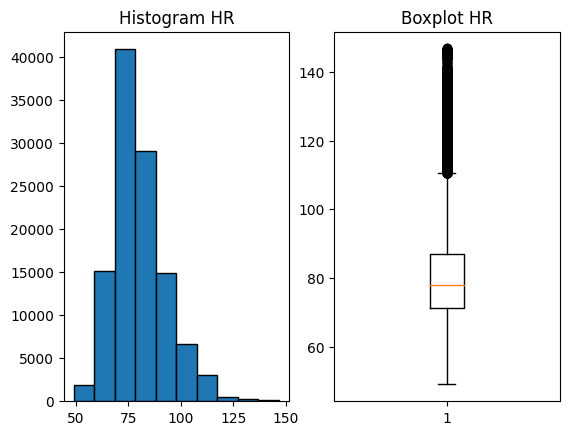

<Figure size 1500x800 with 0 Axes>

In [ ]:
graph_variables("HR")

#### - Intepretation:

Looking the univarite analysis for the response variable `HR`, we can easily observe that almost follow a normal distribution but a litle skewed to the right. Also, we can see that migh be outliers present in the variable.

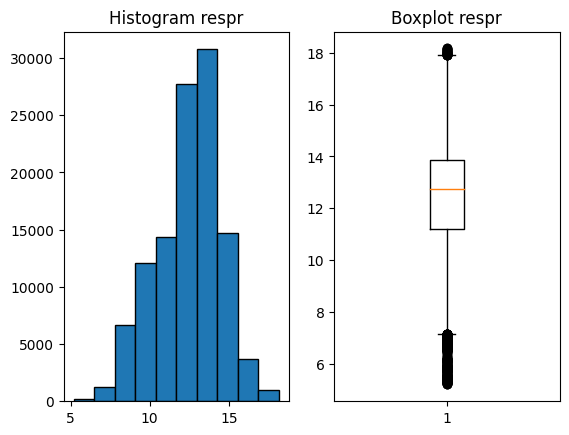

<Figure size 1500x800 with 0 Axes>

In [ ]:
graph_variables("respr")

#### - Intepretation:

Looking the univariete analysis for the response variable `respr`, we can easily observe that `respr` almost follow a bell shape distribution. Also, we can see that migh be outliers present in the variable.

##### **- Outliers Interpretation:**

We think that outliers should not be eliminated in this kind of experimental design measuring as predictor stress over time because it is crucial to carefully consider the nature of data, potential causes of outliers, and the impact on the analysis of these points. The principal reasons are:

* Preserving data integrity: Outliers may contain valuable information and reflect important characteristics of the data. Removing outliers can distort the underlying patterns and relationships in the data, leading to biased or inaccurate results.
* Reflecting real-world variability: Outliers can occur naturally due to various factors such as individual differences between the subjects or groups, measurement errors, or unexpected events. In a quasi-experimental design, it is important to capture the natural variability of stress levels and related physiological responses. Removing outliers may result in an overly idealized or unrealistic representation of the data.
* Robustness of statistical analysis: Many statistical techniques used for analyzing data, such as regression models, are designed to handle a certain degree of outliers. These methods are often robust and can provide reliable results even in the presence of outliers. Eliminating outliers may not be necessary if appropriate statistical techniques are employed.



Text(0, 0.5, 'HR')

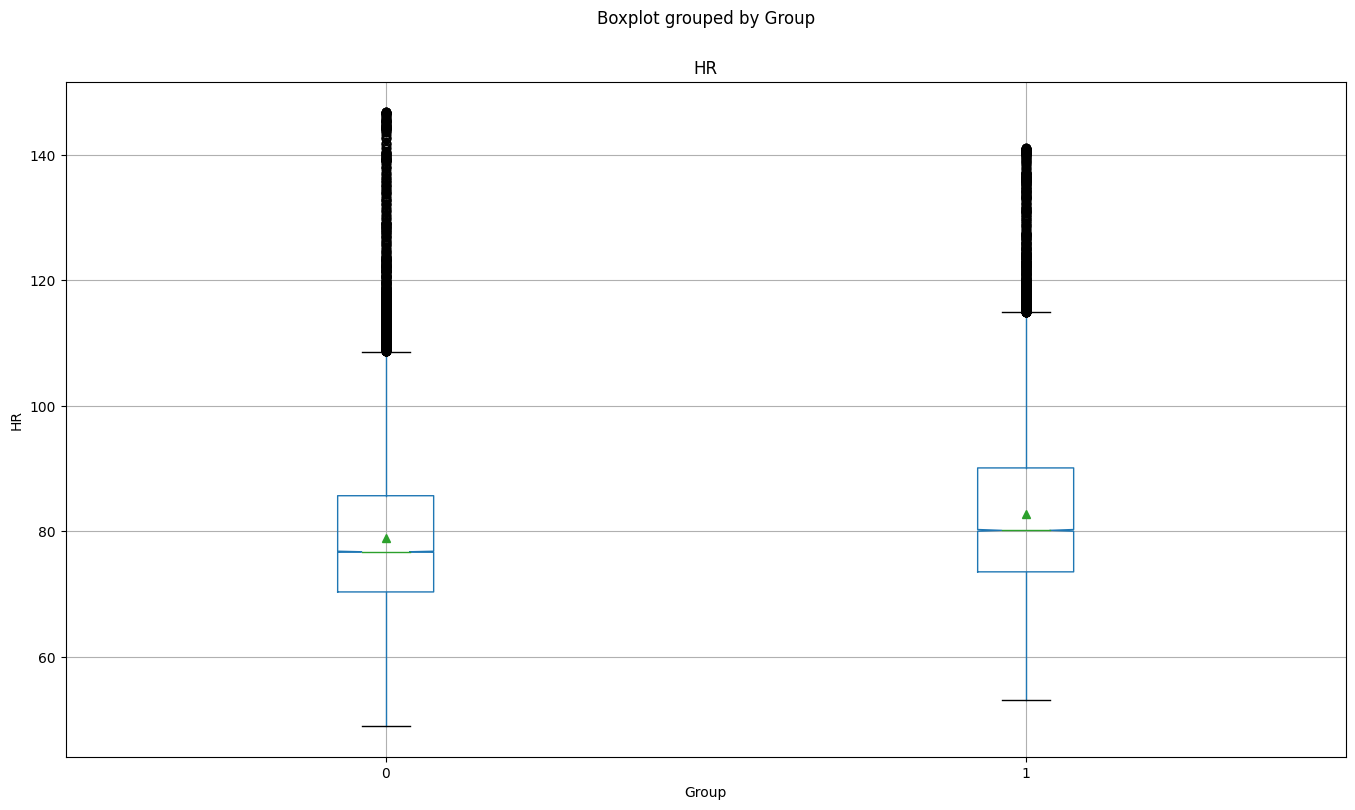

In [ ]:
boxplot = df.boxplot(["HR"], by = ["Group"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Group")
boxplot.set_ylabel("HR")


#### - Interpretation:

Looking at the boxplot, the distribution and variances of the `HR` look fairly similar between the Groups. The boxplot also indicates that there may outliers present in both groups.

Text(0, 0.5, 'Respiratory Rate ')

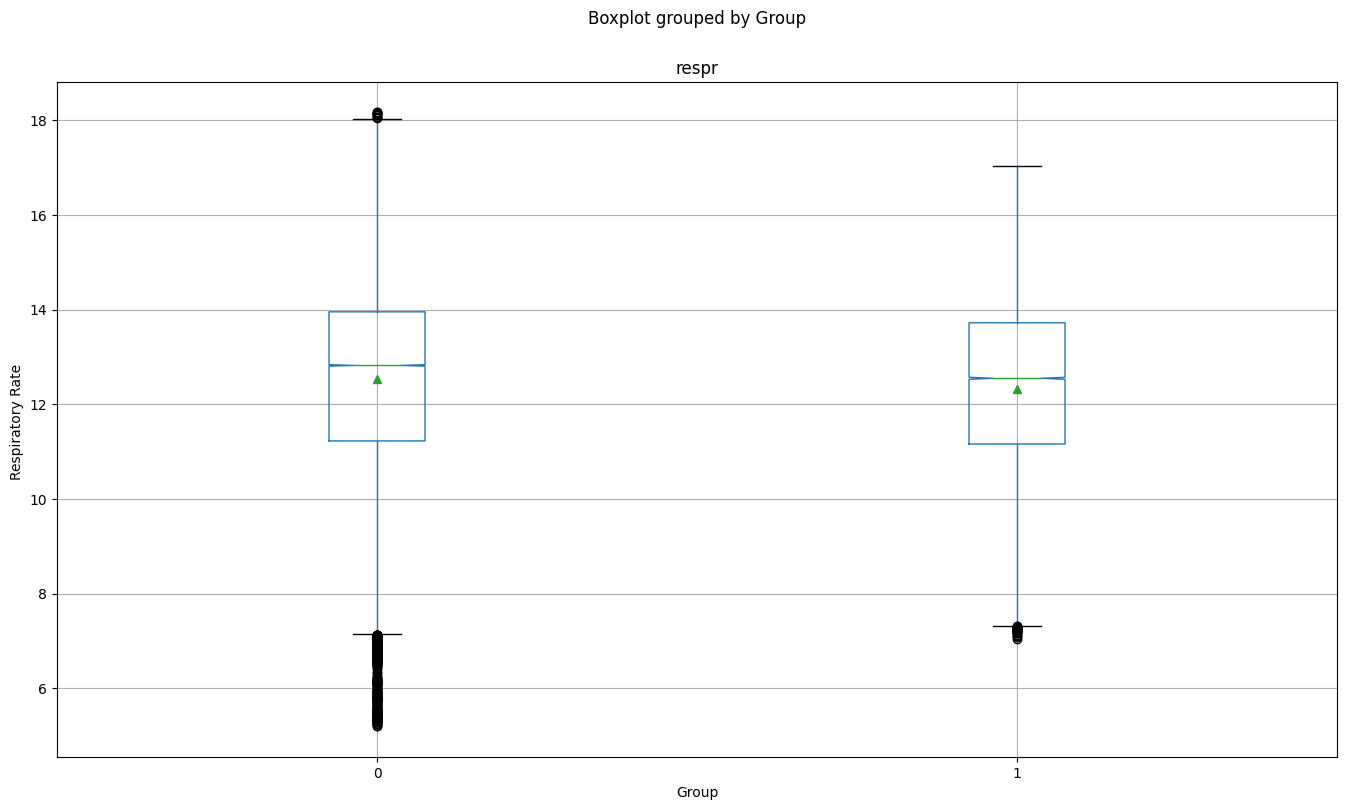

In [ ]:
boxplot = df.boxplot(["respr"], by = ["Group"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Group")
boxplot.set_ylabel("Respiratory Rate ")

#### - Interpretation:

Looking at the boxplot, the distribution and variances of the `RR` look fairly similar between the Groups. The boxplot also indicates that there may outliers present in both groups, but more in the Group 0(normal).

Text(0, 0.5, 'HR')

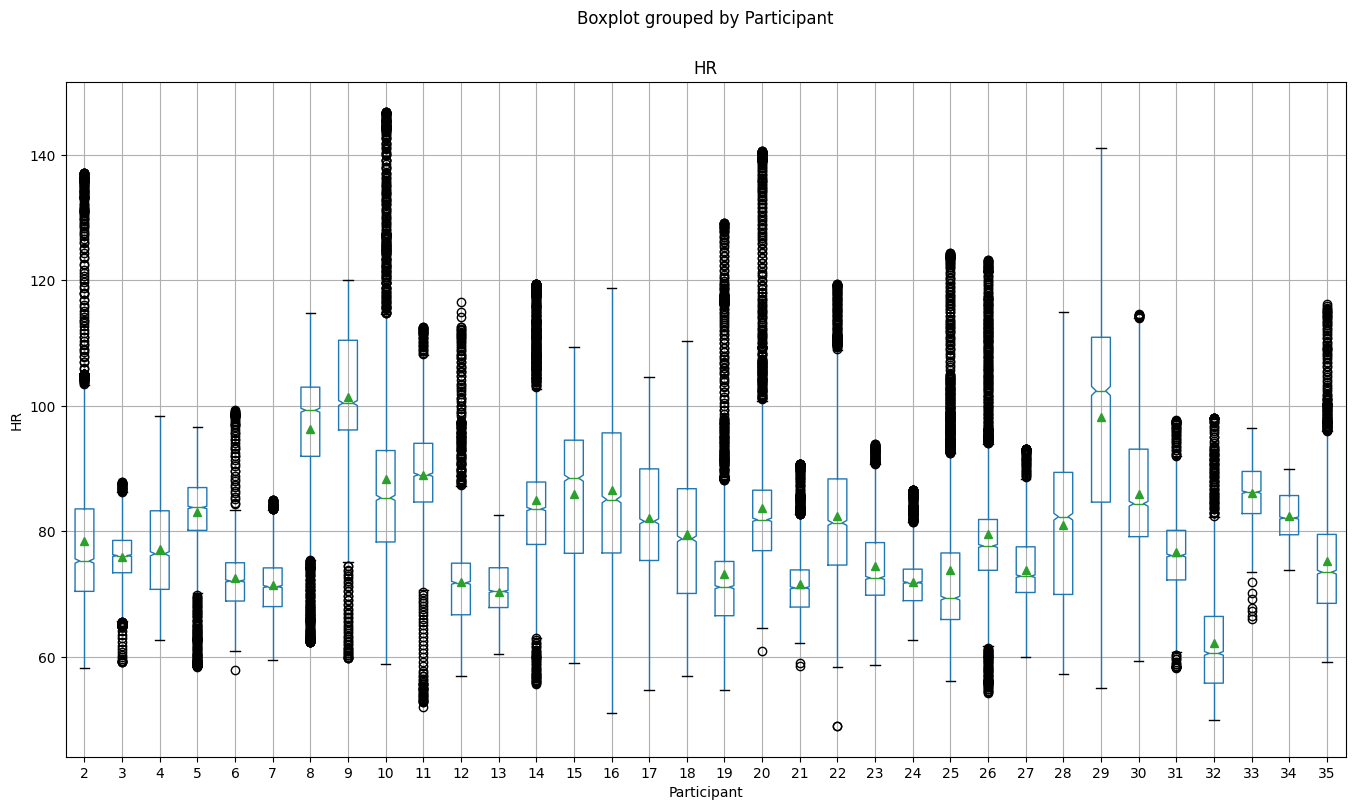

In [ ]:
boxplot = df.boxplot(["HR"], by = ["Participant"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Participant")
boxplot.set_ylabel("HR")


Text(0, 0.5, 'HR')

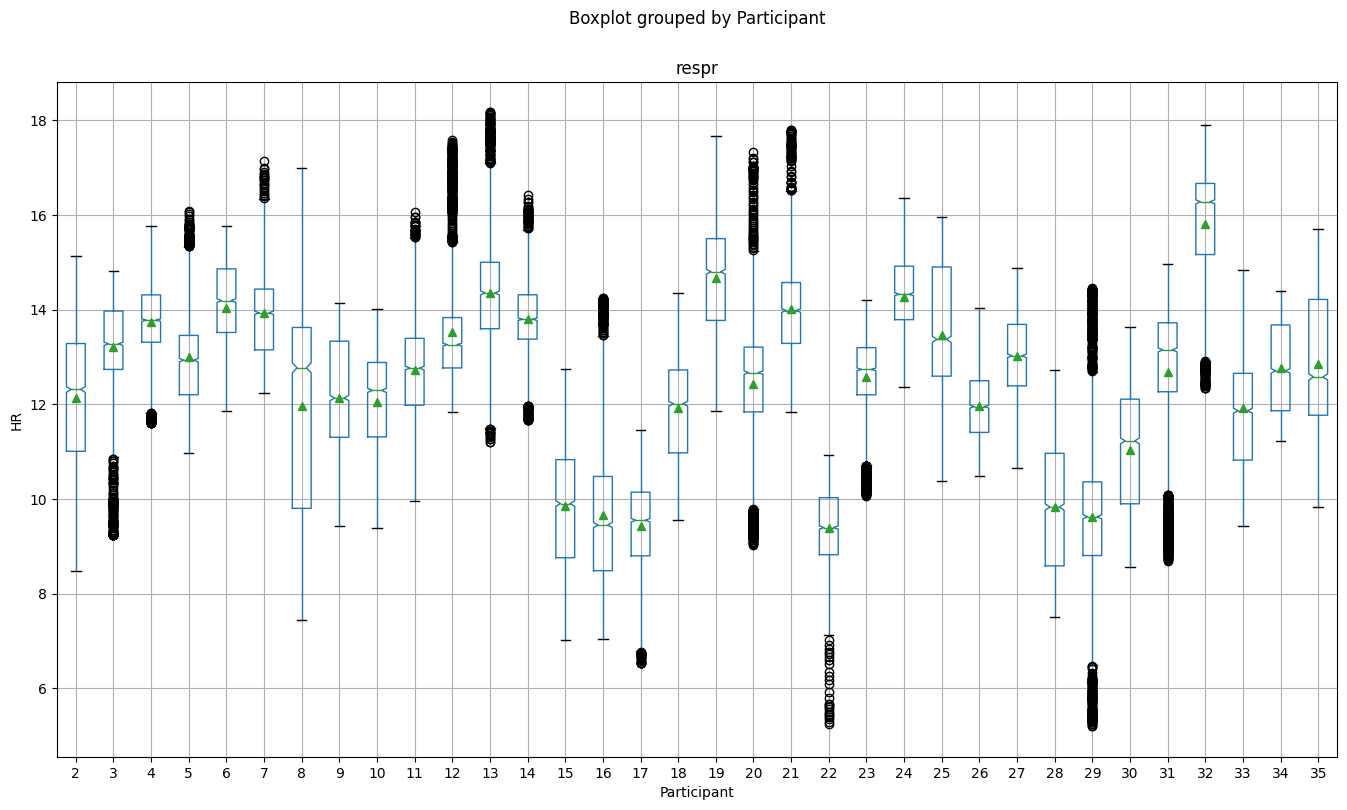

In [ ]:
boxplot = df.boxplot(["respr"], by = ["Participant"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Participant")
boxplot.set_ylabel("HR")

#### - Interpretation:

As we mentioned in the description analysis of statistics values above, the variance of `HR` and `respr` between each subject are very differents and also we can see some outliers in the data points. It is normal that the data could have that variance because is the human nature to have differents reactions and differents emotions during stress situations.

##### **- Correlation:**

To see correlation between the variables we are going to oibserve scatterplot and pearson correlation between the  variables.

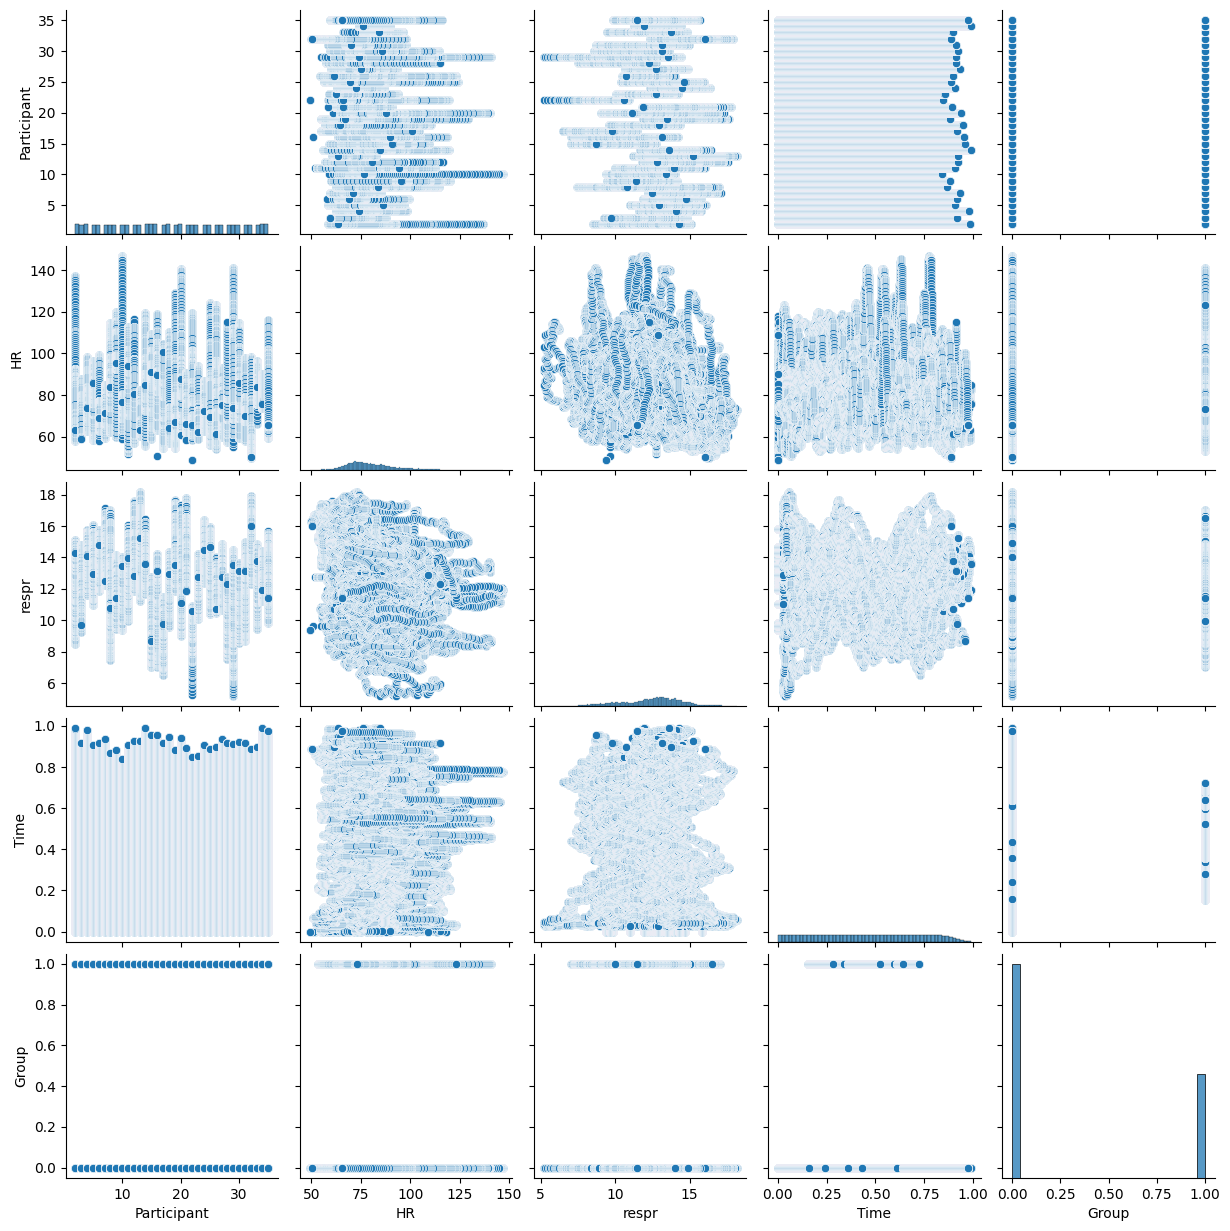

In [ ]:
sns.pairplot(df)

Since one of the assumptions of the Linear Mixed-Effect model is that the response and explanatory variables have a linear relationship, we will calculate their correlation through Pearson's indicator and plot heatmap:

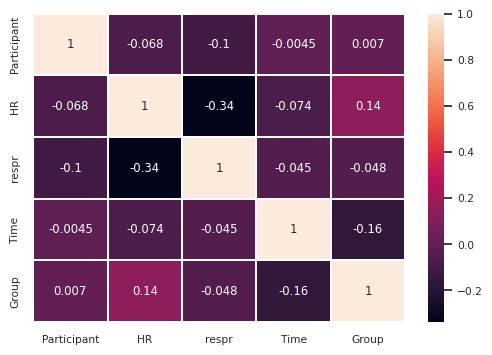

In [ ]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (6, 4))
sns.heatmap(df.corr(), annot = True, linewidths = 0.01, linecolor = 'white')
plt.show()

#### - Interpretation:

We interpret the results of the Pearson's correlation as follows:

Weak correlation: 0 < |r| < 0.3<br>
Moderate correlation: 0.3 < |r| < 0.7<br>
Strong correlation: |r| > 0.7<br>

Therefore, the table and heatmap above show there is not a strong nor moderate correlation between the datasets' variables, therefore, we will perform a new correlation analysis but taking into account that the dataset has repeated measurements (by Participant) with the Repeated measures correlation (rmcorr) function:

In [ ]:
df.columns

Index(['Participant', 'HR', 'respr', 'Time', 'Group'], dtype='object')

In [ ]:
variables = ['HR', 'respr', 'Time', 'Group']

In [ ]:
for i, var1 in enumerate(variables):
  for j, var2 in enumerate(variables[i + 1:], start = i + 1):
    x = variables[i]
    y = variables[j]
    res = pg.rm_corr(data = df, x = x, y = y, subject = 'Participant')
    print(f"Correlation between {x} and {y}:")
    print(res)
    print('\n')

Correlation between HR and respr:
                r     dof      pval           CI95%     power
rm_corr -0.014421  112437  0.000001  [-0.02, -0.01]  0.997985


Correlation between HR and Time:
                r     dof           pval          CI95%  power
rm_corr -0.093082  112437  8.769571e-215  [-0.1, -0.09]    1.0


Correlation between HR and Group:
                r     dof  pval        CI95%  power
rm_corr  0.189445  112437   0.0  [0.18, 0.2]    1.0


Correlation between respr and Time:
                r     dof           pval           CI95%  power
rm_corr -0.077034  112437  1.487710e-147  [-0.08, -0.07]    1.0


Correlation between respr and Group:
               r     dof           pval           CI95%  power
rm_corr -0.07987  112437  1.666752e-158  [-0.09, -0.07]    1.0


Correlation between Time and Group:
                r     dof  pval           CI95%  power
rm_corr -0.162459  112437   0.0  [-0.17, -0.16]    1.0




#### - Interpretation:

After performing different correlation analyses (by variable and by Participant group vs variable) we can conclude does not exist moderate or strong correlation between the variables, the highest one is between HR and respr which have a negative weak correlation value of -0.34.

## Objective 2. Identify ways to reduce dimensions of the datasets.

### Disclaimer:
-It is crucial to understand that PCA is most effective when applied to correlated variables. If we do not adhere to this assumption, it becomes challenging to interpret the results of the principal components accurately. The underlying principle of PCA is to capture and represent the patterns of variability within the dataset by identifying the directions of maximum variance.

When variables are not correlated or exhibit weak correlations, applying PCA may not yield meaningful insights. In such cases, the principal components may not effectively capture the underlying structure of the data. Therefore, it is important to consider the correlation among variables before applying PCA and interpret the results with caution.

### There are two ways that we can reduce dimention reducion in a dataset of numerical variables.

1. By columns:
We can reduce the dimensionality while preserving the most important information by identifying variables that are correlated with each other. We can then obtain the principal components based on a desired level of explained variance. In our dataset, for example, `HR` and `respr` are low(-0.33) correlated continuous variables. If we can find a way to reduce these two variables to a single component that captures 80% of their combined variance, it would be a good example of dimensionality reduction. However, since `HR` and `respr` are the response variables in our linear mixed model, it may not be meaningful to perform such reduction on them. On the other hand, our predictors, such as Time (not suitable for PCA) and Label (a categorical variable representing groups), as well as Participants (identifying repeated measurements), are not suitable for PCA. Therefore, in this case, performing PCA may not be appropriate. However, in order to apply PCA  for a academy purpose we can do it, even though those variables are response of the model and it is not good practice to do that.

If we were to try logistic regression to predict the Label variable using `HR` and `respr` as predictors, it could be a good example to consider PCA using `HR`, `respr`, and possibly `Time` (We are going to show a simple example with this practical case).

2. By rows (transposing the dataset):
In this approach, we can consider reducing the columns to obtain principal components that capture the most variance across the rows, based on a desired level of variance. This method is particularly useful when our goal is to analyze patterns or relationships among the rows rather than the columns. By reducing the rows, we aim to capture the underlying structure or trends within the dataset.

However, in our specific dataset, transposing the rows may not be advantageous. Each point in the `Time` variable is highly correlated with the subsequent rows because the time values are almost similar for consecutive points. This high correlation between successive rows limits the potential for dimensionality reduction using this approach.

Furthermore, it does not make sense to reduce the `Group` variable within the rows as it is a binary variable with limited variability. The `Group` variable serves as a categorical indicator and does not contribute to the potential reduction in dimensions.

Therefore, considering the nature of our dataset, the transposing of rows for dimensionality reduction may not be beneficial.

The second approach we are not going to work on it, because the data itself it not allow us with meaningfull results.

Due to the challenges in applying PCA to this particular dataset, we will proceed with the instructions of this assignment. However, we would also like to demonstrate a practical academic approach by showcasing the implementation of PCA in conjunction with Logistic regression.

## Objective 3: Implement PCA to reduce the dataset's dimensions.

As mentioned earlier, our first approach focuses on reducing dimensionality by considering the columns of the dataset. In this academic exercise aimed at understanding and applying PCA, we are specifically attempting to reduce the dimensionality of the continuous variables `HR` and `respr`, which are the only variables available that exhibit a low correlation.

It is important to acknowledge that both `HR` and `respr` serve as response variables in the linear mixed model. However, for the purpose of practicing PCA in this dataset, we are attempting to combine them into a single linear mixed model. It is crucial to note that changing the response variable is not appropriate in a typical analysis, but in this case, we are solely focusing on practicing PCA techniques.

By combining `HR` and `respr` into one model, we aim to explore dimensionality reduction and understand the impact on the relationship between the predictors and the combined response variable. This exercise allows us to gain hands-on experience with PCA, even though it deviates from the conventional modeling approach.

While it is essential to exercise caution and adhere to proper modeling practices in real-world scenarios, practicing PCA in this controlled academic setting allows us to learn and explore its application in datasets with a specific focus on dimensionality reduction.

##### **- Implementation 1 of PCA:**

In [ ]:
#Filterin the variables to apply PCA
df_lm= df[['HR', 'respr']]

In [ ]:
df_lm.shape # Just checking

(112472, 2)

In [ ]:
df_lm.corr() # As we mentioned is not hight correlated but anyway we are going to use them

,HR,respr
HR,1.000000,-0.336027
respr,-0.336027,1.000000


The Pearson's coefficient shows us there is not strong correlation so the PCA reduction should not be performed but for educational purposes we will continue with the process

In [ ]:
# Scaling the data:
scaler = StandardScaler()

#Fit the data
scaler.fit(df_lm)

#Apply transform to the data.
df_lm_sc = scaler.transform(df_lm)

In [ ]:
df_lm_sc

array([[ 2.96759194, -0.16627981],
       [ 2.61415593, -0.16627981],
       [ 1.00405854, -0.16627981],
       ...,
       [-1.1558282 , -0.47764471],
       [-1.1558282 , -0.49165014],
       [-1.1558282 , -0.50425502]])

In [ ]:
# getting the object PCA
pca = PCA(.9)

In [ ]:
# Fit the object
pca.fit(df_lm_sc)

PCA(n_components=0.9)

In [ ]:
# As we can see the number of components are equal to the number of variables that are two
pca.n_components_

2

In [ ]:
# Getting the PCA array of data
principalComponents= pca.transform(df_lm_sc)
principalComponents

array([[ 2.21598197,  1.9808268 ],
       [ 1.96606497,  1.7309098 ],
       [ 0.82755419,  0.59239902],
       ...,
       [-0.47954815, -1.15503977],
       [-0.46964482, -1.16494311],
       [-0.46073182, -1.17385611]])

In [ ]:
# Getting the results of data
exp_var_pca=pca.explained_variance_ratio_
exp_var_pca

array([0.66801368, 0.33198632])

In [ ]:
per_var= np.round(pca.explained_variance_ratio_*100,decimals=1)
labels= ['PC'+str(x) for x in range(1,len(per_var)+1)]
per_var

array([66.8, 33.2])

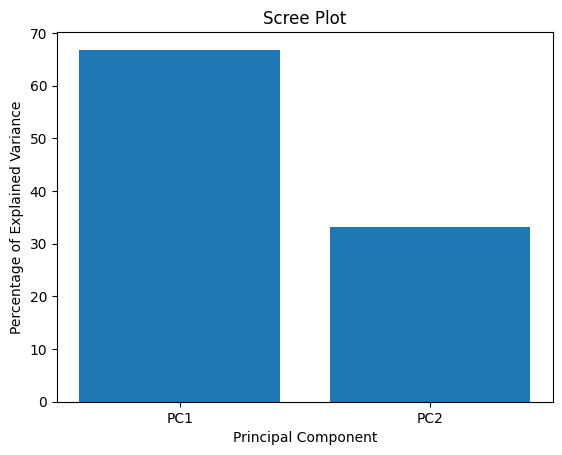

In [ ]:
plt.bar (x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel ('Principal Component')
plt.title('Scree Plot')
plt.show()

As observed, the first principal component explains 67% of the variance. In light of this, we will proceed by utilizing PCA1 as the response variable in the mixed linear model. By doing so, we aim to explore the relationship between the predictors and the variability captured by the first principal component.

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_lm.columns)
loadings

,PC1,PC2
HR,0.707107,0.707107
respr,-0.707107,0.707107


As we can observe there is to much different in the loading of the variables

In [ ]:
# Obtaing a dataset with names of the variables
principal_lm = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_1', 'principal_component_2'])

In [ ]:
# Checking the shape to be sure
principal_lm.shape

(112472, 2)

In [ ]:
#Checking the shape
df.shape

(112472, 5)

In [ ]:
#Concatenaring the both datasets
df_pca = pd.concat([principal_lm.reset_index(drop=True), df[['Time', 'Group','Participant']].reset_index(drop=True)], axis = 1)
df_pca.shape

(112472, 5)

We can see that in this model there is not to much different in the points of PCA1 and PCA2 if we try to see the cluster for Group 0 and Group 1 in the classification task with logiastic regression.

## Objective 4. Conduct the prediction tasks using the linear model.

But first we are going to split the data at 20% for the test.

In [ ]:
#extrating the training and test set
df_train, df_test= train_test_split(df_pca, test_size = 0.20, random_state = 5)
print(df_train.shape)
print(df_test.shape)

(89977, 5)
(22495, 5)


In [ ]:

y_train=df_train[['principal_component_1']]
X_train=df_train.drop(['principal_component_1','principal_component_2'],axis=1)
y_test=df_test[['principal_component_1']]
X_test=df_test.drop(['principal_component_1','principal_component_2'],axis=1)

In [ ]:
#definig function for the metrics

def parameters(model):
    y_prediction_train = model.predict(X_train)
    y_prediction_test = model.predict(X_test)

    rmse = mean_squared_error(y_train, y_prediction_train)
    mae = mean_absolute_error(y_train, y_prediction_train)
    mape= mean_absolute_percentage_error(y_test,  y_prediction_test)
    r2 = r2_score(y_train, y_prediction_train)


    rmse_test = mean_squared_error(y_test,  y_prediction_test )
    mae_test = mean_absolute_error(y_test,  y_prediction_test )
    mape_test= mean_absolute_percentage_error(y_test, y_prediction_test)
    r2_test = r2_score(y_test,  y_prediction_test)

    return pd.DataFrame({'Train Parameters':[rmse,mae,mape, r2],'Test Parameters':[rmse_test,mae_test,mape_test, r2_test]},index=['RMSE','MAE','MAPE','R2'])




In [ ]:
# Run LMER with the first componets that captures the 67% of the variance
md = smf.mixedlm('principal_component_1 ~ Time + C(Group) + Time:C(Group)', df_train, groups=df_train['Participant'], re_formula='~1+Time')
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())
print(parameters(mdf))

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: principal_component_1
No. Observations: 89977   Method:             REML                 
No. Groups:       34      Scale:              0.4043               
Min. group size:  2418    Log-Likelihood:     -87182.6748          
Max. group size:  2862    Converged:          Yes                  
Mean group size:  2646.4                                           
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept            -0.073     0.192  -0.382  0.702  -0.450   0.303
C(Group)[T.1]         0.056     0.012   4.587  0.000   0.032   0.080
Time                 -0.034     0.157  -0.214  0.831  -0.342   0.275
Time:C(Group)[T.1]    0.574     0.028  20.557  0.000   0.520   0.629
Group Var             1.253     0.463                   

In [ ]:
coefficients= mdf.params[:4]
coefficients

Intercept            -0.073382
C(Group)[T.1]         0.056128
Time                 -0.033617
Time:C(Group)[T.1]    0.574339
dtype: float64

In [ ]:
random_effects = mdf.random_effects
random_effects

{2: Group    0.548413
 Time    -1.109767
 dtype: float64,
 3: Group   -0.435312
 Time    -0.099639
 dtype: float64,
 4: Group   -0.315085
 Time    -0.585629
 dtype: float64,
 5: Group   -0.047245
 Time     0.030448
 dtype: float64,
 6: Group   -0.788404
 Time    -0.424677
 dtype: float64,
 7: Group   -1.363748
 Time     0.783017
 dtype: float64,
 8: Group    0.269220
 Time     1.834463
 dtype: float64,
 9: Group    2.111340
 Time    -1.833626
 dtype: float64,
 10: Group   -0.003272
 Time     1.450218
 dtype: float64,
 11: Group    0.379740
 Time     0.023431
 dtype: float64,
 12: Group   -1.051700
 Time     0.451288
 dtype: float64,
 13: Group   -1.471621
 Time     0.554942
 dtype: float64,
 14: Group   -0.536964
 Time     0.656214
 dtype: float64,
 15: Group    1.135480
 Time     0.201873
 dtype: float64,
 16: Group    1.753542
 Time    -0.886155
 dtype: float64,
 17: Group    1.020682
 Time     0.312942
 dtype: float64,
 18: Group    0.463831
 Time    -0.644667
 dtype: float64,
 19: 

## objective 5: Interpret the result of the predictions.

#### - Interpretation of the coefficients and p_value:
* Intercerpt: When the values of the predictors is cero, the average value of PCA1 is -0.073. The result of the coefficient is negative and when is negative does not make sense. However, we have to consider that we modify the response variable
* Group[T.1]:  The average difference in the PCA1 variable is 0.056 between the Group 1 (Stress) and the Group 0 (Normal) while holding constants the other predictor variables. However, the p-value for this variable is < 0.05, which means Group variable is statiscally significant for the model.
* Time: When Time variable changing in 1 unit, the PCA1 variable will dicrease in average, 0.034 units. However, the p-value for this variable is > 0.05, which means Time variable is not  statiscally significant for the model.
* Time*Group[T.1]: When Time variable changing in 1 unit, for the Stress Group the PCA1 variable will increase by 0.574 units.

### Intepretation of metrics:


RMSE : It measures the average magnitude of the differences between the predicted values and the actual values. A lower RMSE indicates better model performance. In this case, the RMSE for the training dataset is 1.318531, while for the testing dataset it is 1.304934.
MAE (Mean Absolute Error): It measures the average magnitude of the differences between the predicted values and the actual values, without considering the direction of the differences. Like RMSE, a lower MAE indicates better model performance. The MAE for the training dataset is 0.916940, and for the testing dataset it is 0.911704.
MAPE (Mean Absolute Percentage Error): It measures the average percentage difference between the predicted values and the actual values. MAPE is useful when the magnitude of the errors is significant and needs to be understood in relation to the actual values. The MAPE for both the training and testing datasets is 1.632781, indicating a 1.63% average percentage error in the predictions.
R2 (Coefficient of Determination): It represents the proportion of the variance in the dependent variable (PCA1 in this case) that can be explained by the independent variables. R2 ranges from 0 to 1, where a higher value indicates a better fit of the model to the data. The R2 for the training dataset is 0.014860, while for the testing dataset it is 0.016147.

Based on these results, it appears that the model performance is not very strong, as indicated by the relatively high errors (RMSE and MAE) and low R2 values. It suggests that the predictors might not have a strong relationship with the response variable(PCA1), and the model may not effectively capture the underlying patterns in the data. It is normal to have this result because we changed the response variable, so that is  why it suggest that the predictors included in the model may not be strongly associated with the variation in PCA1. It's important to consider the limitations of using PCA1 as the response variable and the potential implications of using this unconventional approach. Additionally, further analysis and consideration of alternative modeling techniques may be necessary to improve the predictive performance for PCA1.

### Objective 6. Compare the results with the study’s results.

To compare the results of the study we are going to evaluate our assumptions that we made as we mentioned before, try to analyze the parts that the article mentions about the data and validate the results that we obtain.

##### **- Assumptions:**

* Missing values: We eliminate missing values as well as the article did because we can see that the number of observations or the sample size in the article is equal to 112,472 for both models.
* Sample Size: The paper does not mention the number of samples that were used to train the model, we split the data in 80:20. 80 for the training and 20% for the test.
* The random seed also can change a little bit the result but not should change the trend of the result if the data is balance.
* Outliers: The article does not mention anything about the outliers and we decided not to eliminate them because of the nature of the data.
* Ramdon effect: We decided to put `Time` as a random effect as mentioned in the article.
* Fixed Effect: The article mentions clearly that Group and the interaction term of Time and Group should be fixed effect.

##### **- Results: Article's parameters vrs Model's Parameters:**


#### HR Model


| Predictors | Article Parameters| P_value | Model Parameters| P_value |
| --- | --- | --- | --- | --- |
| Intercept | 80.36| 0.001 | -0.073| 0.702|
| Time| -2.65 | 0.105 | -0.034 | 0.831|   
|Group[Stress] | 1.40 |0.001 | 0.056 | 0.000 |
| Time* Group[Stress]| 5.05 | 0.001 | 0.0574 | 0.000 |





| Predictors | Article Parameters| P_value | Model Parameters| P_value |
| --- | --- | --- | --- | --- |
| Intercept | 12.664| 0.001 | -0.073| 0.702|
| Time| -0.30 | 0.408 | -0.034 | 0.831|    
|Group[Stress] | 0.20 |0.001 |  0.056 | 0.000 |
| Time* Group[Stress]| −1.11 | 0.001 | 0.0574 | 0.000 |


#### - Interpretation:

* As we can see in both models the Intercept is not the same. That means in general when the predictor of `HR` or `respr` is cero `HR`= 80.298 and `respr`=12.677.However, in our model is not statiscally significant and the negative sign does not make sense.
* In the case of the predictor `Time` the p_value show that is not statistically significant important in the model(p_value>0.05). Also, Time is set with a random slope because HR differs from each subject.  
* The predictor `Group` is statistically significant and important to the model (p_value<0.05).
* The interaction term between `Time and Group` is statistically significant and important even though the term `Time` is not statistically significant. In our model and the article are the same results as significant important.
* The coefficients for `HR` model and `respr` model is not exactly the same the difference is quite big. Also, we can notice as mentioned before the p_value shows the same results in the article and our model, except for the intercept.

As mentioned previously, we anticipated these results because modifying the response variable is not typically done in practical cases. Consequently, our results differ from what is expected in the literature. Nonetheless, this approach serves as a practical exercise for implementing PCA in this specific dataset.

##### **- Normality asumption of residual:**
In this part we try to validate our results and compare the results of the article.

<ipython-input-316-c6b17e933ec6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


Text(0.5, 0, 'Residuals')

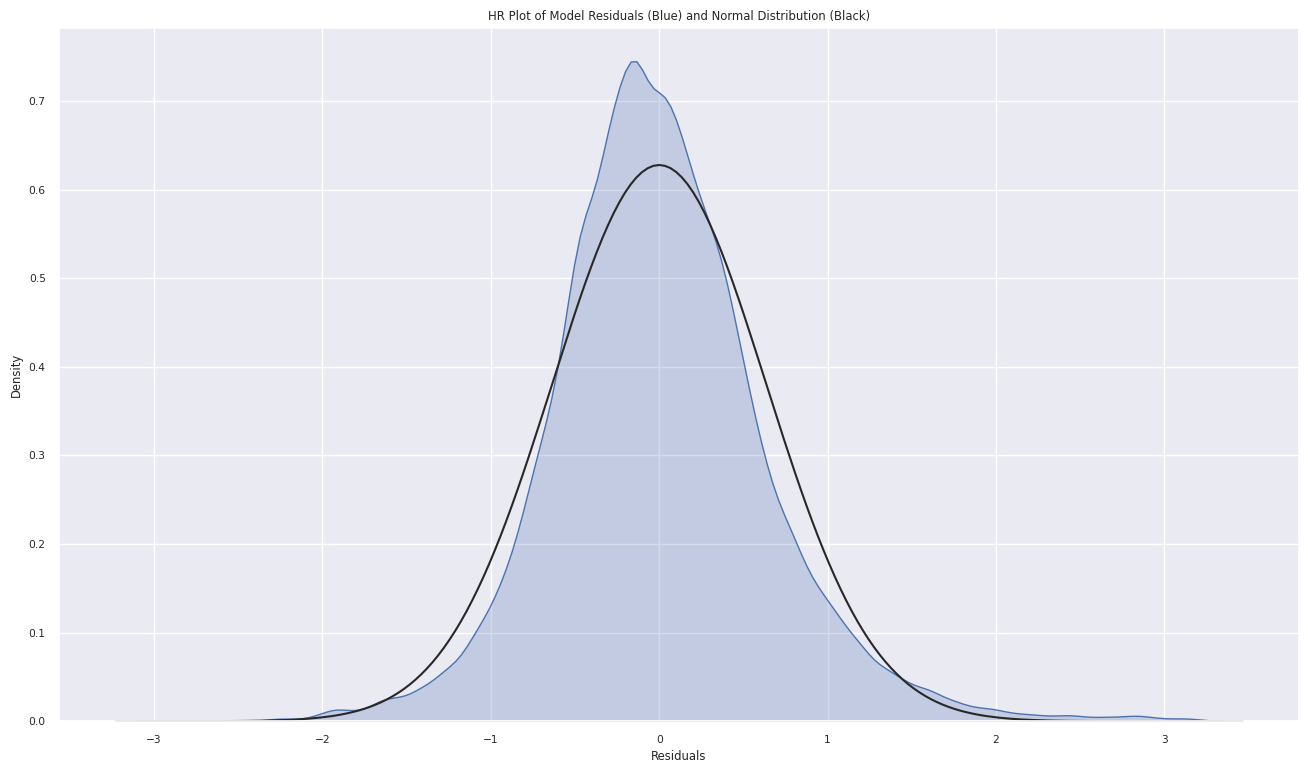

In [ ]:
import scipy.stats as stats
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(mdf.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("HR Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

#### - Interpretation:
Although there is a slight departure from normality in the data, it does not appear to be a significant concern. Furthermore, there is an outliers that are clearly visible in the plots. That shows that the data might need to be improved a little bit.




##### **- Homoscedasticity of variances, assumption of residual:**

In this part, we try to validate our results and compare the results of the article.

Text(0.5, 0, 'Fitted Values')

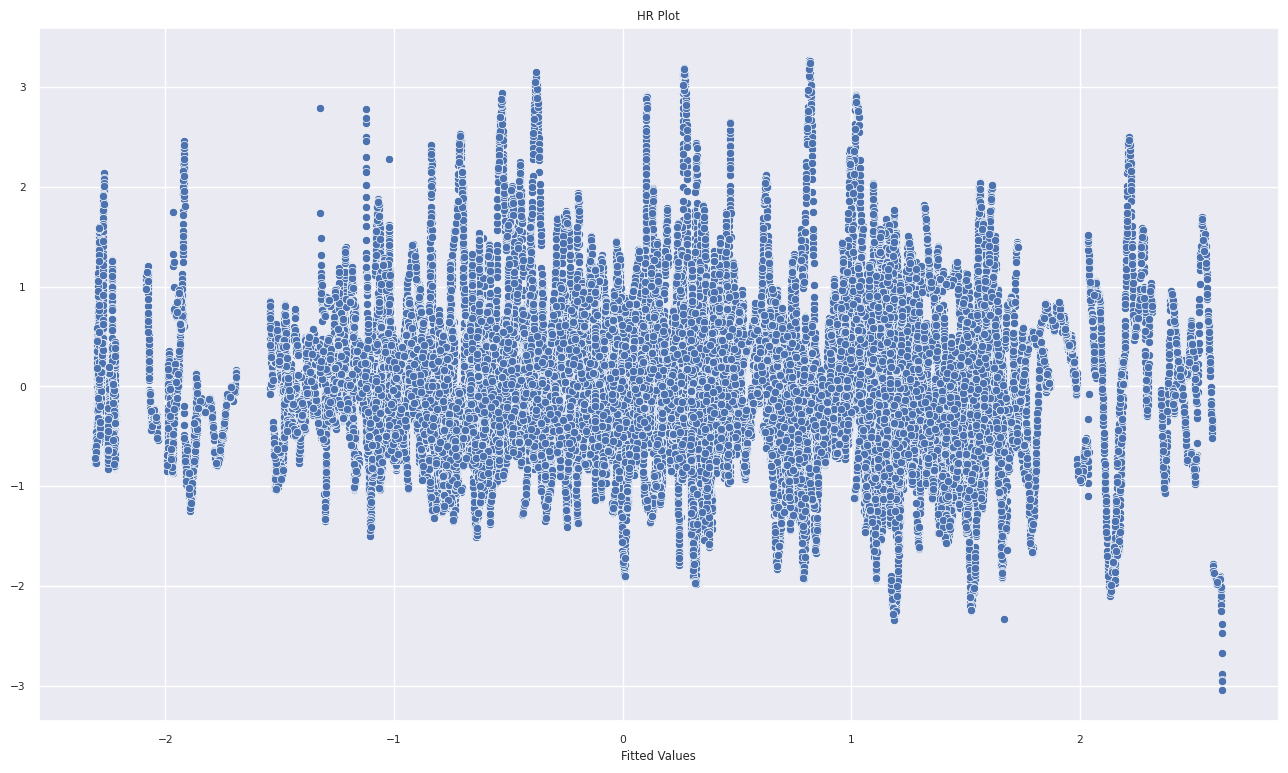

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = mdf.resid, x = mdf.fittedvalues)

ax.set_title("HR Plot")
ax.set_xlabel("Fitted Values")

#### - Interpretation:

* According to the visual tests,  boths plots that not shows any specific pattern, there seems to be little cause for concern regarding the violation of the assumption of homoscedasticity (equal variance).



### Additional implementation of PCA: Logistic Regression

Approach by columns :
As mentioned earlier, implementing PCA by columns in our dataset may yield noisy and less meaningful results for a Lineal Mixed Model. Therefore, an alternative approach we can consider is building a logistic regression model using our dataset. In this model, we can attempt to predict the "Label" variable while using "HR" and "respr" as predictors. To further explore the dimensionality reduction aspect, we can apply PCA on these variables to capture the most variance in the principal components.

It's important to note that this exercise serves as an academic practice for understanding PCA and its potential applications in different datasets and models. The logistic regression with PCA serves as an example to illustrate the concept and showcase one of the many ways PCA can be utilized.

In [ ]:
df['Group'].value_counts()

0    75657
1    36815
Name: Group, dtype: int64

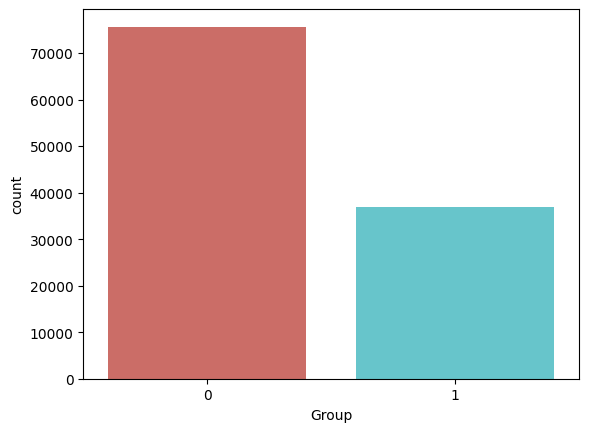

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.countplot(x='Group',data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In the given dataset, we can observe the counts of each group, namely the Normal Group(0) and the Stress Group(1). It is evident that the Normal group has a larger number of samples. Although the dataset is not perfectly balanced, we have an adequate amount of data to proceed with our analysis.

In [ ]:
df.groupby('Group').mean()

,Participant,HR,respr,Time
Group,,,,
0,18.427442,78.980513,12.533615,0.490431
1,18.575553,82.755539,12.325215,0.397808


We are going to use now the dimention reduction of PCA that we did before for the variables `HR` and `respr` and make a plot to see if there is differents cluster for Stress Group and Normal Group

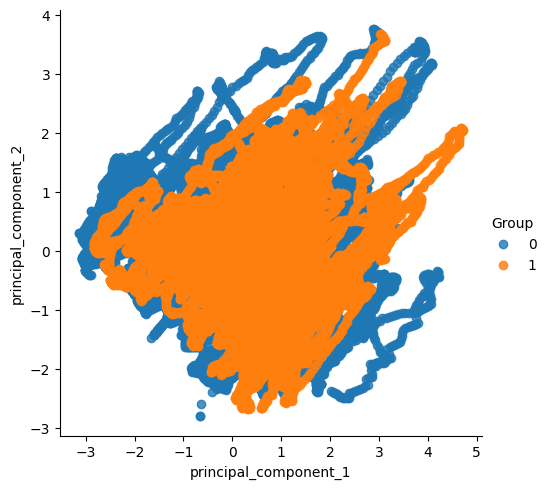

In [ ]:
sns.lmplot(x='principal_component_1',y='principal_component_2',
           data=df_pca, hue = 'Group' ,fit_reg=False, aspect=1)

As depicted in the plot, there is no distinct cluster that can be clearly identified for each group. However, both groups exhibit a similar pattern in their data.

Now, we are going to create a Logistic regression model as example how to use it for the logistic regression model

In [ ]:
df_train, df_test= train_test_split(df_pca, test_size = 0.20, random_state = 5)
print(df_train.shape)
print(df_test.shape)

(89977, 5)
(22495, 5)


In [ ]:
y_train=df_train[['Group']]
X_train=df_train.drop(['Group','principal_component_2'],axis=1)
y_test=df_test[['Group']]
X_test=df_test.drop(['Group','principal_component_2'],axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
# parameters not specified are set to their defaults
# just solver change for
logisticRegr = LogisticRegression(solver= 'newton-cholesky', max_iter=200, C=0.2, penalty='l2')
logisticRegr.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.2, max_iter=200, solver='newton-cholesky')

In [ ]:
y_test

,Group
83688,0
98318,0
107891,1
78686,0
60604,1
...,...
8329,1
109753,1
9265,0
102757,0


In [ ]:
logisticRegr.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

#### Measuring Model Performance

In [ ]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.6465881306957102



The score of 0.65 represents the mean accuracy on the test data and labels. It demonstrates a satisfactory level of classification, but there is always room for improvement.

This scenario serves as a useful illustration of applying PCA to two variables, such as HR and respr, as predictors in a logistic regression model. However, it is important to note that this is an additional application and not the primary objective of this assignment.


# 5. Conclusions

* The missing value of the data set represents less than 5% of the data so we decided to drop them. The article does not mention the missing values but shows the number of observations that they used is exactly the same as what we obtained after we dropped the missing values in the dataset.

* We decided not to modify the outliers due to the nature of the quasi-experiment and the data itself.

* We explored the application of PCA in reducing the dimensionality of a dataset with the goal of practicing and understanding its implementation. While our approach of using PCA on the response variables and modifying them for the purpose of creating a single linear mixed model is not conventional, it allowed us to gain insights into the process and evaluate the model's performance. The results indicated that using PCA1 as the response variable did not yield strong predictive performance, as indicated by the relatively high errors and low R2 values. These findings emphasize the importance of considering the appropriateness of the modeling techniques and the limitations of manipulating the response variable. Nonetheless, this exercise provided valuable practical experience in working with PCA and highlights the need for careful consideration of appropriate methodologies for future analyses.

* When we applied PCA to reduce the dimensions of HR and respr, even though they had a low correlation, we found that the first principal component explained 67% of the variance of the two variables. It is remarkable that we were able to successfully reduce the dimensionality and utilize only one variable instead of both in our model. However, it is crucial to consider that PCA is generally more suitable for variables that exhibit high correlation in order to obtain meaningful and interpretable results.

* The sample size to train the model was 80% of the data with a random sample of it.

 * The term `Group` was set as a Fixed effect as mentioned in the article. The p_value for this variable showed statistically significant importance in the  models with p_value < 0.05.

* The term `Time` was considered as a Random effect for the individual since we have repeated measures in the same subjects then the data points of `Time` for every `Participant` depend on each other. In this case, we allowed to have different intercepts and slopes for every Participant but those are random. This variable `Time` was not statistically significant important for our model with p_value > 0.05 as the article results.


* The coefficients of `PCA1` Model as response gave us similar results compared to the article, which means could simulate the model. Just taking into consideration the statistical significance of the term (p_values) we can say are results are similar as well.

* The variable participant was set as part of the cluster for the mixed linear model that we have.


* Although our main objective was to perform a mixed linear model and apply PCA, we deviated from it and instead demonstrated a practical example of applying PCA to the variables HR and respr as predictors in a logistic regression model. This deviation allowed us to explore the process of PCA and understand how it can be utilized in this particular dataset. While it was not aligned with our original objective, it served as a valuable exercise in applying PCA and showcased the potential of this technique for variable reduction and prediction. It is important to note that our intention was not to compare the results with the original dataset and assess any differences in model accuracy, but rather to present a practical example.
